In [1]:
import os
import sys
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Soc 225\\Soc-225\\Final Project'

In [2]:
# importing libraries & making torch.device object for GPU

# neural network packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset

# data packages
import h5py
import numpy as np

# visual packages
import matplotlib.pyplot as plt
%matplotlib inline

#other
from functions import experiment
import inspect

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
hdf = h5py.File('../../Data/CCSN_Pan_SNR_Free.h5', 'r')

signals = {
    'NR': hdf['Model_NR']['Hp'], # NR: No Rotation
    'SR': hdf['Model_SR']['Hp'], # SR: Slow Rotation
    'FR': hdf['Model_FR']['Hp'], # FR: Fast Rotation
    'Noise': hdf['Noise']['Strain']
}

signals['NR'].shape, signals['SR'].shape, signals['FR'].shape, signals['Noise'].shape

((50000, 8192), (50000, 8192), (50000, 8192), (150000, 8192))

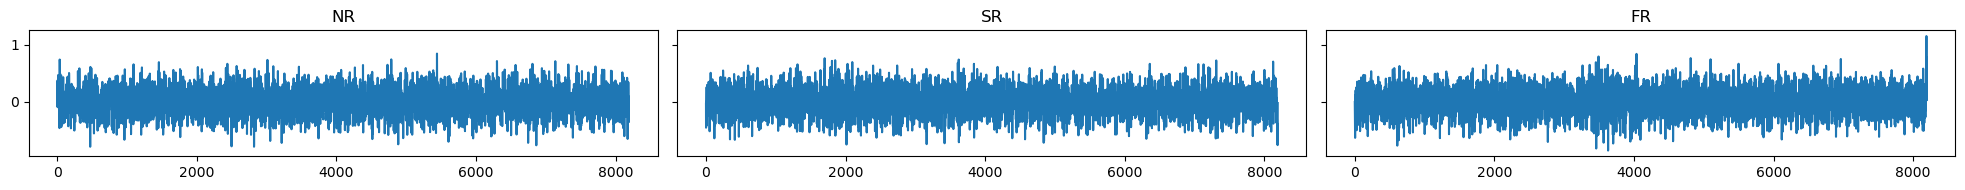

In [4]:
''' 
signal types (classes)
    - NR: No Rotation
    - SR: Slow Rotation
    - FR: Fast Rotation
    - Noise

one sample 
    - classified as a signal type (NR, SR, FR) or noise
    - array of shape 8192 x 1 (strain measurements)

50k samples of each class
''';

fig, axs = plt.subplots(1, 3, figsize=(20, 2), sharex=True, sharey=True)

axs[0].plot(signals['NR'][0])
axs[0].set_title('NR')

axs[1].plot(signals['SR'][0])
axs[1].set_title('SR')

axs[2].plot(signals['FR'][0])
axs[2].set_title('FR')

plt.tight_layout()
plt.show()

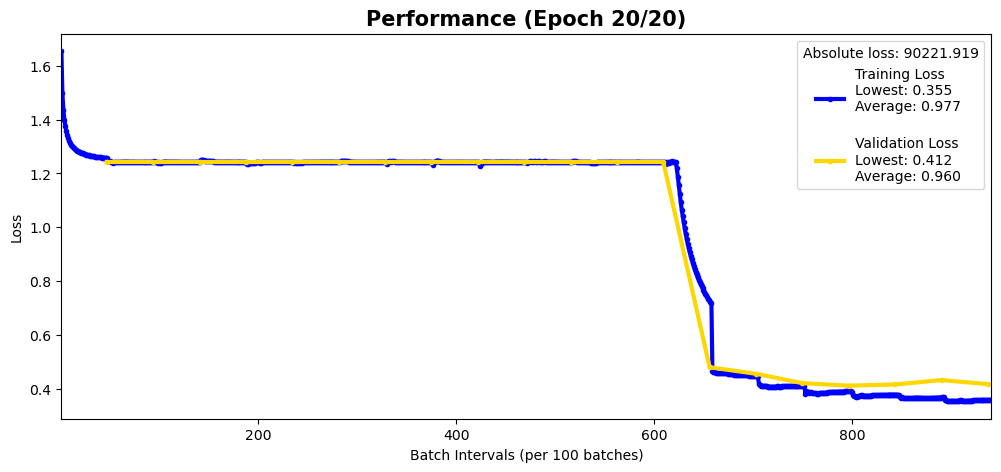

90221.91918291897

<Figure size 640x480 with 0 Axes>

In [5]:
class SignalDataset(Dataset):
    def __init__(self, signals, signal_type):
        data_np = np.array(signals[signal_type])
        self.data = torch.tensor(data_np, dtype=torch.float32)
        self.labels = torch.tensor([0 if signal_type == 'NR' else 1 if signal_type == 'SR' else 2 if signal_type == 'FR' else 3 for _ in range(len(data_np))], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

print('loading training data', end='\r')

# Create datasets
print('creating training datasets', end='\r')
nr_dataset = SignalDataset(signals, 'NR')
sr_dataset = SignalDataset(signals, 'SR')
fr_dataset = SignalDataset(signals, 'FR')
noise_dataset = SignalDataset(signals, 'Noise')

# Combine datasets
print('combining training datasets', end='\r')
full_dataset = ConcatDataset([nr_dataset, sr_dataset, fr_dataset, noise_dataset])

# Create training dataloader
print('creating train DataLoader', end='\r')
batch_size = 64
train_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)


# =====================================================================================

print('loading test data', end='\r')
hdf_test = h5py.File('../../Data/GW1_CCSN_Pan_SNR_Free_Test_Validation.h5', 'r')

test_signals = {
    'NR': hdf_test['Model_NR']['Hp'], # NR: No Rotation
    'SR': hdf_test['Model_SR']['Hp'], # SR: Slow Rotation
    'FR': hdf_test['Model_FR']['Hp'], # FR: Fast Rotation
    'Noise': hdf_test['Noise']['Strain']
}

print('creating test datasets', end='\r')
nr_test_dataset = SignalDataset(test_signals, 'NR')
sr_test_dataset = SignalDataset(test_signals, 'SR')
fr_test_dataset = SignalDataset(test_signals, 'FR')
noise_test_dataset = SignalDataset(test_signals, 'Noise')

print('combining test datasets', end='\r')
test_dataset = ConcatDataset([nr_test_dataset, sr_test_dataset, fr_test_dataset, noise_test_dataset])

print('creating test DataLoader', end='\r')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# =====================================================================================
class SignalClassifier(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32, out_channels=64, conv_kernel_size=5, pool_kernel_size=2, pool_stride=2, dropout=0.5, leak=0.1, input_size=8192):
        super(SignalClassifier, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.conv_kernel_size = conv_kernel_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.dropout = dropout
        self.leak = leak
        self.input_size = input_size

        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=conv_kernel_size)
        self.conv2 = nn.Conv1d(in_channels=hidden_channels, out_channels=out_channels, kernel_size=conv_kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_stride)
        
        # Calculate the size after conv and pooling layers
        conv_output_size = self.get_size(input_size, conv_kernel_size, pool_kernel_size, pool_stride)
        
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.fc2 = nn.Linear(128, 4)  # output classes
    
    def get_size(self, input_size, conv_kernel_size, pool_kernel_size, pool_stride):
        # Helper function to calculate the output size after conv and pooling layers
        size = input_size
        size = (size - (conv_kernel_size - 1) - 1) // pool_stride + 1  # After conv1 and pool1
        size = (size - (conv_kernel_size - 1) - 1) // pool_stride + 1  # After conv2 and pool2
        return size * 64  # Multiply by the number of output channels of the last conv layer

    def params(self):
        init_params = inspect.signature(self.__init__).parameters
        return {name: getattr(self, name) for name in init_params if name != 'self'}

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = nn.Dropout(self.dropout)(x)
        x = nn.LeakyReLU(self.leak)(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = nn.Dropout(self.dropout)(x)
        x = nn.LeakyReLU(self.leak)(x)

        x = x.view(x.size(0), -1)  # Flatten layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SignalClassifier(
    input_size=8192,
    in_channels=1, 
    hidden_channels=32, 
    out_channels=64, 
    conv_kernel_size=5, 
    pool_kernel_size=2, 
    pool_stride=2, 
    dropout=0.5, 
    leak=0.4
).to(device)
nnet = experiment(model, train_loader, test_loader, batch_size);

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


print('training model', end='\r')
nnet.train(optimizer, loss_function, epochs=20)

In [6]:
def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_loss = running_loss / len(data_loader)
    return accuracy, avg_loss

# Evaluate the model
test_accuracy, test_loss = evaluate(model, test_loader, loss_function)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.4166, Test Accuracy: 0.8677
